# Business Problem Understanding

-**Previously, we explored Is there a relationship between total advertising spend and sales? .**

-**What is the relationship between each advertising channel (TV, Radio, Newspaper) and sales?**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

## Data Understanding

Load Data & Understand every variable

In [2]:
df=pd.read_csv('Advertising.csv')
df.head()

,TV,radio,newspaper,sales
0,230100,37800,69200,22100
1,44500,39300,45100,10400
2,17200,45900,69300,9300
3,151500,41300,58500,18500
4,180800,10800,58400,12900


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   TV         200 non-null    int64
 1   radio      200 non-null    int64
 2   newspaper  200 non-null    int64
 3   sales      200 non-null    int64
dtypes: int64(4)
memory usage: 6.4 KB


In [4]:
df.shape

(200, 4)

In [5]:
df.columns.tolist()

['TV', 'radio', 'newspaper', 'sales']

In [6]:
continuous=['TV', 'radio', 'newspaper', 'sales']
df[continuous].describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147042.500000,23264.000000,30554.000000,14022.500000
std,85854.236315,14846.809176,21778.620839,5217.456566
min,700.000000,0.000000,300.000000,1600.000000
25%,74375.000000,9975.000000,12750.000000,10375.000000
50%,149750.000000,22900.000000,25750.000000,12900.000000
75%,218825.000000,36525.000000,45100.000000,17400.000000
max,296400.000000,49600.000000,114000.000000,27000.000000


<Axes: >

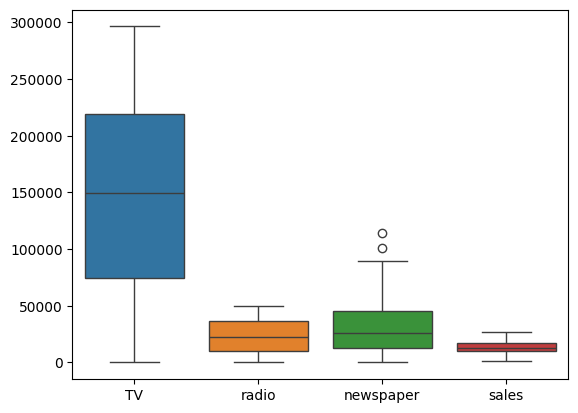

In [7]:
sns.boxplot(df[continuous])

In [8]:
for i in continuous:
    q3=df[i].quantile(0.75)
    q1=df[i].quantile(0.25)
    iqr=q3-q1
    
    upper_limit=(q3+(1.5*iqr))
    lower_limit=(q1-(1.5*iqr))
  
    outlier_indices=df[(df[i]<lower_limit)|(df[i]>upper_limit)].index.tolist()
    print(f"Outliers in {i} columns are {outlier_indices}")

Outliers in TV columns are []
Outliers in radio columns are []
Outliers in newspaper columns are [16, 101]
Outliers in sales columns are []


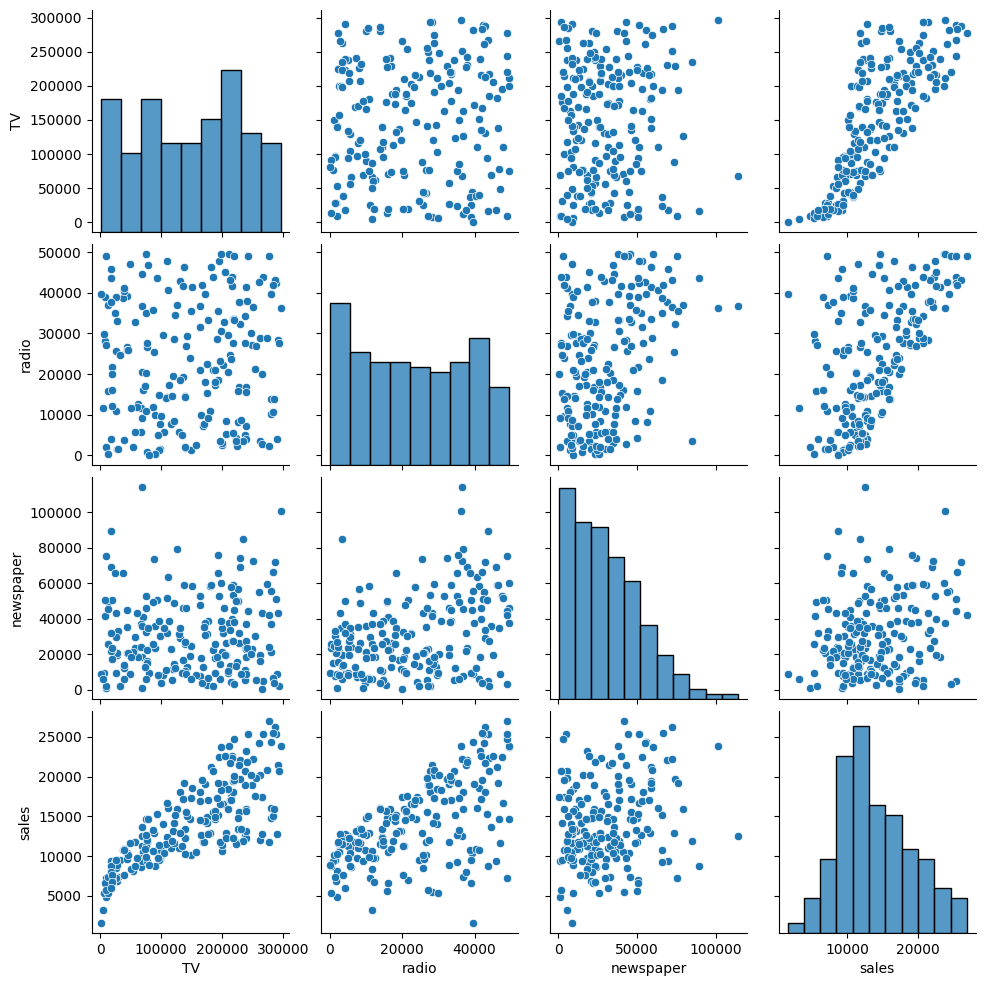

In [9]:
sns.pairplot(df[continuous])
plt.show()

In [10]:
df.isnull().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

In [11]:
df.duplicated().sum()

0

In [12]:
df[continuous].skew()

TV          -0.069853
radio        0.094175
newspaper    0.894720
sales        0.407571
dtype: float64

<Axes: >

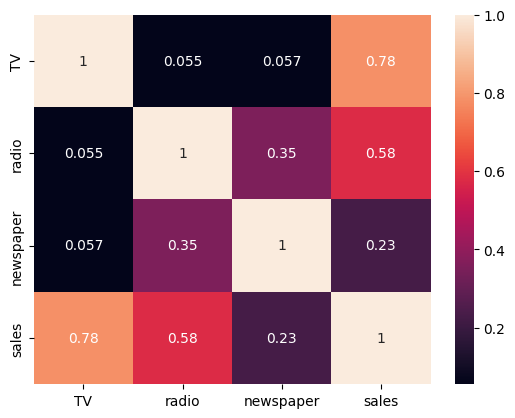

In [13]:
sns.heatmap(df[continuous].corr(),annot=True)

##### No correlation between independent variables...Hence, no colinearity problem

# Variance Inflation Factor (VIF)

In [14]:
import statsmodels.formula.api as smf

rsq_TV=smf.ols('TV~radio+newspaper',data=df).fit().rsquared
vif_TV=1/1-rsq_TV

rsq_radio=smf.ols('radio~TV+newspaper',data=df).fit().rsquared
vif_radio=1/1-rsq_radio

rsq_newspaper=smf.ols('newspaper~radio+TV',data=df).fit().rsquared
vif_newspaper=1/1-rsq_newspaper

d1={'Variables':['TV','radio','newspaper'],'VIF':[vif_TV,vif_radio,vif_newspaper]}
VIF_frame=pd.DataFrame(d1)
VIF_frame

,Variables,VIF
0,TV,0.995410
1,radio,0.873399
2,newspaper,0.873220


# Key points about VIF values:

##### VIF = 1: 
No correlation between the predictor variable and other variables, ideal situation.

##### VIF between 1 and 5: 
Moderate correlation, usually considered acceptable.

##### VIF greater than 5: 
High correlation, potential for problematic multicollinearity.

##### VIF greater than 10: 
Severe multicollinearity, likely need to take action to address it. 

In [15]:
X=df[['TV', 'radio', 'newspaper']]
y=df['sales']

# **Find best random state number**

In [16]:
Train_r2_score=[]
CV=[]

for i in range(0,100):
    from sklearn.model_selection import train_test_split
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=i)

    from sklearn.linear_model import LinearRegression
    model=LinearRegression()
    model.fit(X_train,y_train)

    ypred_train=model.predict(X_train)
    
    from sklearn.metrics import r2_score
    Train_r2_score.append(r2_score(y_train,ypred_train))

    from sklearn.model_selection import cross_val_score
    CV.append(cross_val_score(model,X_train,y_train,cv=5).mean())

em=pd.DataFrame({'Train_r2_score':Train_r2_score,'CV':CV})
gm=em[(abs(em['Train_r2_score']-em['CV'])<=0.05)]
rs=gm[gm['CV']==gm['CV'].max()].index.tolist()[0] #index.tolist()[0] extracts the index (random state) of that best-performing row.

print("Best Random state number is ",rs)   

Best Random state number is  10


In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=rs)

## Modelling

In [18]:
from sklearn.linear_model import LinearRegression

model=LinearRegression()
model.fit(X_train,y_train)
print("Coefficient:- ",model.coef_)
print("Intercept:- ",model.intercept_)

Coefficient:-  [ 0.0437726   0.19343299 -0.00222879]
Intercept:-  3254.097114418886


## Evaluation

In [19]:
ypred_train=model.predict(X_train)

from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

print("Train r2 score:- ",r2_score(y_train,ypred_train))
print("CV score:- ",cross_val_score(model,X_train,y_train,cv=5).mean())

ypred_test=model.predict(X_test)
print("Test r2 score:- ",r2_score(y_test,ypred_test))

Train r2 score:-  0.9209087553499528
CV score:-  0.9157327701186169
Test r2 score:-  0.8353672324670592


### OLS
Ordinary Least Squares (OLS) model is a statistical technique used to fit linear regression models. It's a common method for analyzing the relationship between one or more explanatory variables and a continuous outcome variable.

In [20]:
from sklearn.model_selection import train_test_split
df_train,df_test=train_test_split(df,test_size=0.2,random_state=rs)
import statsmodels.formula.api as smf
model1=smf.ols('y_train~X_train',data=df_train).fit()  # y_train~X_train==(sales~TV+radio+newspaper)-test_data
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_train   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     605.5
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           1.09e-85
Time:                        23:05:26   Log-Likelihood:                -1381.9
No. Observations:                 160   AIC:                             2772.
Df Residuals:                     156   BIC:                             2784.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3254.0971    286.349     11.364      0.000    2688.475    3819.719
X_train[0]     0.0438      0.001     32.429      0.000       0.041       0.046
X_train[1]     0.1934      0.008     24.310      0.000       0.178       0.209
X_train[2]    -0.0022      0.005     -0.415      0.679      -0.013       0.008
==============================================================================
Omnibus:                       12.534   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.333
Skew:                          -0.697   Prob(JB):                      0.00127
Kurtosis:                       3.233   Cond. No.                     4.46e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.46e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

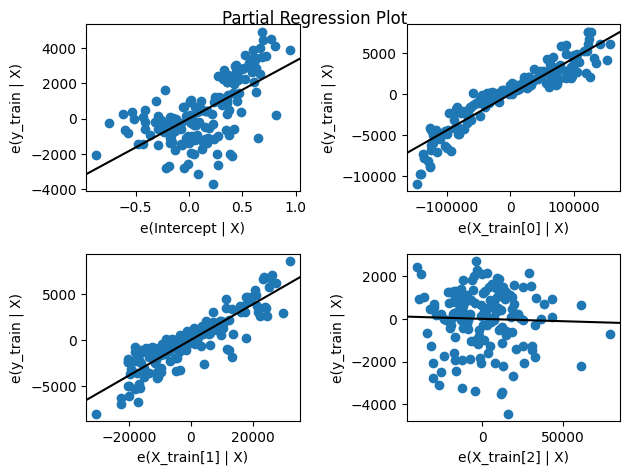

In [21]:
import statsmodels.api as sm
sm.graphics.plot_partregress_grid(model1)
plt.show()

### Influence Plot
influence plot, helps identify outliers and highly influential data points in your regression model.

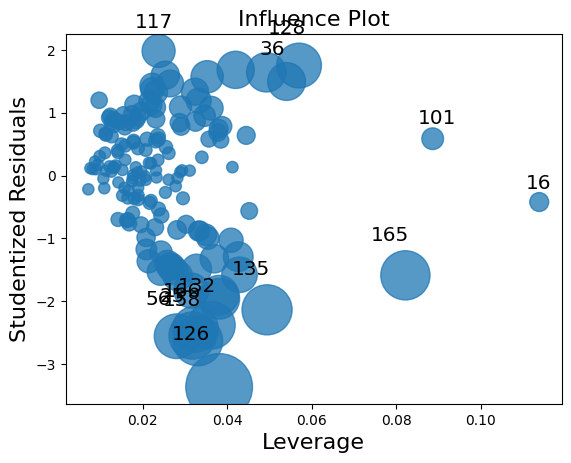

In [22]:
import statsmodels.api as sm
sm.graphics.influence_plot(model1)
plt.show()

In [23]:
influence = model1.get_influence()
cooks_d = influence.cooks_distance[0]
threshold = 4 / len(df_train)  # General rule of thumb
high_influence_points = np.where(cooks_d > threshold)[0]
high_influence_points

array([  0,   8,  16,  26,  37,  45,  59,  65,  71,  85,  87, 102, 119,
       125, 130, 135], dtype=int64)

In [24]:
df.drop(index=[130,5,75,165,101,16,128,36],inplace=True)

X=df.drop(columns='sales')
y=df['sales']

from sklearn.model_selection import train_test_split,cross_val_score
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=rs)

from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(X_train,y_train)

print(f"Coefficient:- {model.coef_}")
print(f"Intercept:- {model.intercept_}")

ypred_train=model.predict(X_train)

from sklearn.metrics import r2_score
print(f"Train R2_score:- {r2_score(y_train,ypred_train)}")
print(f"Train CV_score:- {(cross_val_score(model,X_train,y_train,cv=5)).mean()}")

ypred_test=model.predict(X_test)
print(f"Test R2_score:- {r2_score(y_test,ypred_test)}")

Coefficient:- [0.04231835 0.19018805 0.01162628]
Intercept:- 3187.802420142445
Train R2_score:- 0.9186337181540609
Train CV_score:- 0.9039524436092407
Test R2_score:- 0.8901435248440224


In [25]:
from sklearn.model_selection import train_test_split
df_train,df_test=train_test_split(df,train_size=0.8,random_state=rs)

import statsmodels.formula.api as smf
model2=smf.ols("y_train~X_train",data=df_train).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_train   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     560.7
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           6.32e-81
Time:                        23:05:27   Log-Likelihood:                -1330.4
No. Observations:                 153   AIC:                             2669.
Df Residuals:                     149   BIC:                             2681.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3187.8024    305.095     10.449      0.000    2584.932    3790.673
X_train[0]     0.0423      0.001     29.315      0.000       0.039       0.045
X_train[1]     0.1902      0.009     21.513      0.000       0.173       0.208
X_train[2]     0.0116      0.007      1.666      0.098      -0.002       0.025
==============================================================================
Omnibus:                       12.667   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.043
Skew:                          -0.742   Prob(JB):                     0.000893
Kurtosis:                       2.985   Cond. No.                     4.50e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
df.drop(columns=['newspaper'],inplace=True)

X=df.drop(columns=['sales'])
y=df['sales']

In [27]:
from sklearn.model_selection import train_test_split,cross_val_score
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=rs)

from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(X_train,y_train)

print(f"Intercept is:- {model.intercept_}")
print(f"Coefficient is:- {model.coef_}")

ypred_train=model.predict(X_train)

from sklearn.metrics import r2_score
print(f"Train R2_score is:- {r2_score(y_train,ypred_train)}")
print(f"CV score is:- {(cross_val_score(model,X_train,y_train,cv=5)).mean()}")

ypred_test=model.predict(X_test)
print(f"Test R2_score is:- {r2_score(y_test,ypred_test)}")


Intercept is:- 3357.7202283404677
Coefficient is:- [0.04254012 0.19615138]
Train R2_score is:- 0.9171180924161672
CV score is:- 0.9037797241797525
Test R2_score is:- 0.8971081979513411


In [28]:
df.head()

,TV,radio,sales
0,230100,37800,22100
1,44500,39300,10400
2,17200,45900,9300
3,151500,41300,18500
4,180800,10800,12900


In [29]:
from sklearn.model_selection import train_test_split
df_train,df_test=train_test_split(df,test_size=0.2,random_state=rs)

import statsmodels.formula.api as smf
model3=smf.ols('y_train~X_train',data=df_train).fit()
model3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_train   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     829.9
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           7.66e-82
Time:                        23:05:27   Log-Likelihood:                -1331.8
No. Observations:                 153   AIC:                             2670.
Df Residuals:                     150   BIC:                             2679.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3357.7202    289.238     11.609      0.000    2786.213    3929.227
X_train[0]     0.0425      0.001     29.422      0.000       0.040       0.045
X_train[1]     0.1962      0.008     24.123      0.000       0.180       0.212
==============================================================================
Omnibus:                       13.858   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.419
Skew:                          -0.776   Prob(JB):                     0.000449
Kurtosis:                       3.093   Cond. No.                     4.19e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.19e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Final Model
#### Independent Variable ~ TV, Radio

Interpreting the coefficients, a 1 unit increase in TV adds spend, sales 0.0425 units. i.e for every 10000$ spend on TV adds, 425 units are sold.

A 1 unit increase in Radio adds spend, sales 0.1962 units. i.e for every 10000$ spend on Radio adds, 1962 units are sold.